In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import interpolate
from sklearn import linear_model

# cluster functions
empty = [0]
point = [1,2]
pair_1 = [3,4,5]; pair_2 = [6,7,8] 
pair_3 = [9,10,11,12]; pair_4 = [13,14,15]
triplet_1 = [16,17,18,19] 
triplet_2 = [20,21,22,23]
triplet_3 = [24,25,26,27,28,29]

def select_cluster(df_corr, clusters):
    clus = []
    for i in clusters:
        clus = clus + i
    clus = np.array(clus)
    return df_corr.iloc[:,clus]

def regularize_dos(df_dos, grid_fine, smooth_width=0, log=False):
    df_dos_fine = pd.DataFrame(index=df_dos.index, columns=['dos_hse'])
    for i in df_dos.index:
        dos = df_dos.loc[i, "dos_hse"]
        grid_coarse = df_dos.loc[i, "energy_hse"]
        if smooth_width > 0:
            box = np.ones(smooth_width)/smooth_width
            dos = np.convolve(dos, box, mode='same')
        f = interpolate.interp1d(grid_coarse,dos)
        df_dos_fine.loc[i,"dos_hse"] = f(grid_fine)
    if log:
        _dos_log = df_dos_fine.copy()
        for i in df_dos_fine.index:
            _dos_log.loc[i,'dos_hse'] = np.log(df_dos_fine.loc[i,'dos_hse']+0.1)
        df_dos_fine = _dos_log
    return df_dos_fine

def weight(df_dos, w_exp):
    w = np.exp(df_dos.gap_hse.values.astype(float)/w_exp)
    #w = np.ones(len(df_dos))
    return w

def calc_reg(corr,x, w):
    xx = np.concatenate(x.values)
    ndos = len(xx)/len(corr)
    xx = xx.reshape(len(corr), int(ndos))
    #reg = linear_model.LinearRegression(fit_intercept=False)
    reg = linear_model.Ridge(fit_intercept=False)
    reg.fit(corr.values, xx, w)
    return reg

def main(mat, clusters, w_exp=0.1, vbm=0, align=False, verbose=False):
    global grid_fine, df_dos_fine, ref_ind
    smooth_width = 5 # the box width used to smooth the density of states
    is_log = False
    #grid_fine = np.arange(2,8,0.02) # grid for the selected energy range
    # read corr matrix and electronic densities
    df_corr = pd.read_csv('corr_{0}.csv'.format(mat), delim_whitespace=True)
    df_dos = pd.read_hdf('dos_{0}.h5'.format(mat))
    # semiconductors only
    # drop metallic structures
    semi = df_dos[(df_dos.gap_hse > 0.2) & (df_dos.has_hse) & (df_dos.ref_hse < -100)].index
    df_corr = df_corr.loc[semi]
    df_dos = df_dos.loc[semi]
    ref_ind = df_dos.gap_hse.idxmax()
    if verbose:
        display(df_dos)
    # interpolate the dos on a specific regular mesh
    #df_dos_fine = regularize_dos(df_dos, grid_fine, smooth_width=smooth_width, log=is_log)
    #
    # alignment wrt Sn-4s
    if align:
        ref_level = df_dos.loc[ref_ind, 'ref_hse']
        delta_ref = df_dos['ref_hse'] - ref_level
        df_dos['dos_hse'] -= delta_ref
    # keep original mesh and data
    df_dos_fine = df_dos
    grid_fine = df_dos.iloc[0]['energy_hse']
    # define training set
    train = df_corr.sample(frac=1)
    df_corr_train = train.loc[:,"corr(0)":"corr(29)"]
    dos_train = df_dos_fine.loc[train.index,'dos_hse']
    # test set
    test = df_corr.drop(train.index)
    df_corr_test = test.loc[:,"corr(0)":"corr(29)"]
    dos_test = df_dos_fine.drop(train.index).loc[:,'dos_hse']
    # include the pair interactions up to the 5th NN, and the triplets up to the 2NN
    corr_train = select_cluster(df_corr_train, clusters)
    corr_test = select_cluster(df_corr_test, clusters)
    #
    w = weight(df_dos.loc[train.index], w_exp)
    reg = calc_reg(corr_train, dos_train, w)
    dos_train_pred = reg.predict(corr_train)
    #dos_test_pred = reg.predict(corr_test)
    #   
    # test the cluster expansion on the test set
    # plot the real dos (gray) and the predicted dos (red)
    plt.rcParams['figure.figsize'] = [10, 20]
    fig, (ax1,ax2) = plt.subplots(2)
    for i in range(len(dos_train)):
        ax1.plot(grid_fine, dos_train.iloc[i]+10*i, color='gray')
        ax1.plot(grid_fine, dos_train_pred[i]+10*i, color='r')
    ax1.set_title("Cluster expanded DOS: Training set")
    # plot the eci vs energy
    for i in range(len(reg.coef_[0])):
        ax2.plot(grid_fine-vbm, reg.coef_[:,i], label=i)
    ax2.set_title("Effective cluster DOS")
    ax2.set_xlim([-0.5,2.2])
    ax2.set_ylim([-50,500])
    ax2.legend()
    #
    return reg

def ecdos(mat,clusters,reg,vbm,write=False):
    # plot DOS vs Temperature using the correlation matrix from MC simulations
    df_mc = pd.read_csv('mc_{0}.csv'.format(mat), delim_whitespace=True)
    df_mc = df_mc[df_mc['T'] <= 1000].reset_index()
    corr_str = []
    for i in range(30):
        corr_str.append("<corr({0:})>".format(i))
    df_corr_mc = df_mc.loc[:,corr_str]
    corr_mc = select_cluster(df_corr_mc, clusters)
    #
    #dos_mc_pred = pred(corr_mc, eci)
    dos_mc_pred = reg.predict(corr_mc)
    #
    # cluster decomposed contribution
    _eci = reg_czts.coef_.T
    _corr = corr_mc.values
    _ecdos = np.zeros(len(_corr.T))
    corr_fraction = np.zeros((len(reg_czts.coef_),)+corr_mc.shape)
    for i in range(len(corr_fraction)): # energy
        for j in range(len(_corr)):     # temperature
            for k in range(len(_corr.T)): # corr
                _ecdos[k] = _corr[j,k]*_eci[k,i]
            #corr_fraction[i,j] = _ecdos/dos_mc_pred[j,i]
            corr_fraction[i,j] = _ecdos
    #
    plt.rcParams['figure.figsize'] = [10, 20]
    fig, (ax, ax1,ax2) = plt.subplots(3)
    norm = mpl.colors.Normalize(vmin=df_mc["T"].min(), vmax = df_mc["T"].max())
    cmap = mpl.cm.get_cmap('jet')
    c = [cmap(norm(temp)) for temp in df_mc["T"]]
    ax.set_xlim([-0.5,2.2])
    ax.set_ylim([-.2, 8])
    #ax.tick_params(labelleft=False)
    grid_ = grid_fine - vbm
    for i in range(len(dos_mc_pred)):
        ax.plot(grid_, dos_mc_pred[i]+df_mc.loc[i,"T"]*0./400, color=c[i])
    cax, _ = mpl.colorbar.make_axes(ax)
    cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm)
    # plot the kesterite reference dos
    ax.plot(grid_, df_dos_fine.loc[ref_ind, "dos_hse"], '--', c='k', label='reference at LT')
    ax.set_xlabel(r'$E-E_{VBM}$ (eV)')
    ax.set_ylabel(r'Temperature-dependent DOS')
    ax.text(0.4, 0.8, mat.upper(), transform=ax.transAxes, fontsize=12)
    ax.legend()
    #
    for i in range(len(dos_mc_pred)):
        ax1.plot(grid_, corr_fraction[:,i,0:3].sum(axis=1), color=c[i])
        ax2.plot(grid_, corr_fraction[:,i,3:].sum(axis=1), color=c[i])
    for ax_ in [ax1,ax2]:
        ax_.set_xlim([-0.5,2.2])
        ax_.set_ylim([-.2,8])
        cax, _ = mpl.colorbar.make_axes(ax_)
        cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm)
    #if write:
    #    plt.savefig('{0}_dos.pdf'.format(mat))
    #
    return corr_fraction, corr_mc

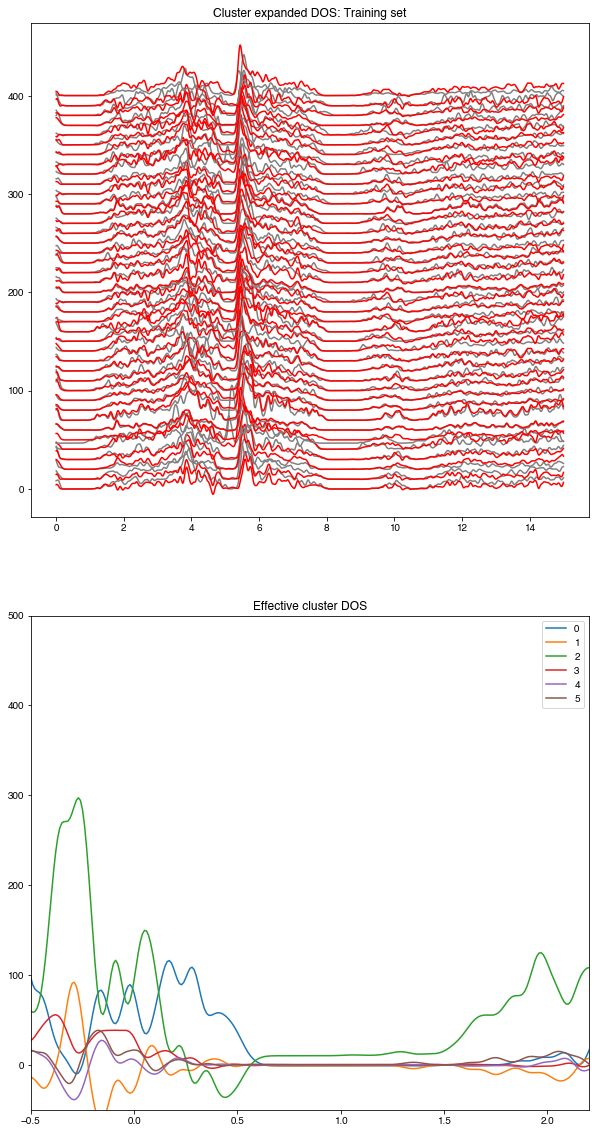

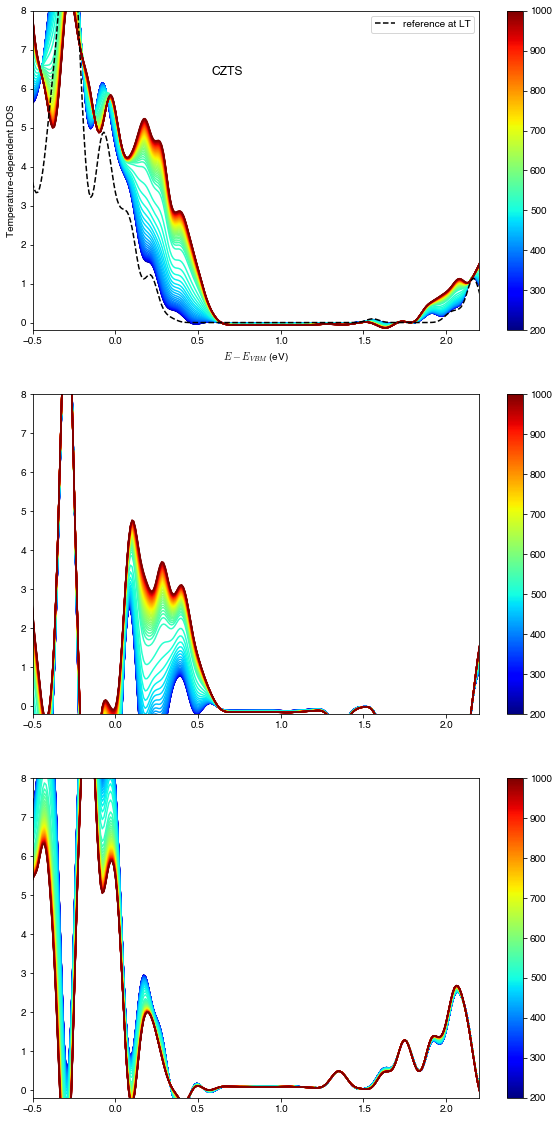

In [2]:
VBM=7.42
clusters = [pair_1, pair_2]
reg_czts = main("czts", clusters, w_exp=0.1, vbm=VBM, align=True, verbose=False)
corr_fraction, corr_mc = ecdos("czts", clusters, reg_czts, vbm=VBM, write=True)

In [ ]:
VBM = 7.29
clusters = [pair_1, pair_2]
eci_ccts = main("ccts", clusters, w_exp=0.1, vbm=VBM, align=False, verbose=False)
ecdos("ccts", clusters, eci_ccts, vbm=VBM, write=True)